In [1]:
import glmnet_python
from glmnet import glmnet

# Import relevant modules and setup for calling glmnet
%matplotlib inline

import time
import sys
import os
import re
from itertools import compress
from glob import glob
import pickle

import tensorflow as tf # data is in TFRecord format

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from scipy.io import loadmat

import numpy as np
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# glmnet has many deprecation warnings from using scipy.* instad of numpy.*
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def plot_distributions(y, y_hat):

    fig, axs = plt.subplots(2, 4, sharey=False, sharex=False, tight_layout=True)
    fig.set_size_inches(20,10)

    for ic in range(0,8):
        idx = np.unravel_index(ic, axs.shape)
        if ic < 4:
            axs[idx].set_title("Real %s"%names[ic])
            x = y[:,ic]        
        else:
            axs[idx].set_title("Predicted %s"%names[ic-4])
            x = y_hat[:,ic-4]
        axs[idx].hist(x, bins=20)

In [2]:
# Define constants
ncores = 28 # 56
names = ['DA', '5HT', 'pH', 'NE']
results_prefix = '/mnt/nfs/proj/in-vitro/Leonardo/glmnet/fits/'
prefix = os.path.join('/mnt/nfs/proj/in-vitro/Mark/four_analyte/slow/allin')
# good_probes = ['CF025']
good_probes = ['CF025', 'CF027']
# good_probes = ['CF025', 'CF027', 'CF057', 'CF064', 'CF066', 'CF078', 'CF081', 'CF082']
# nrecords_per_session = 1 # One is special, loads one sweep per concentration per TFRecord
# nrecords_per_session = 2 # Any other number loads that amount of records in sequence from each TFRecord
nrecords_per_session = -1 # Loads all records
val_ratio = .1
hold_probe = 0
# hold_probe = -1 # split data randomly


In [3]:
# Load data

start_time = time.time()

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    def atoi(text):
        return int(text) if text.isdigit() else text
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def preprocess(serialized_example):
    features = tf.io.parse_example(
        serialized_example,
        features={
            'gram': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.string)
        })
    data = tf.io.decode_raw(features['gram'], tf.float32)
    label = tf.io.decode_raw(features['label'], tf.float32)
    data.set_shape((None, 999))
    label.set_shape((None, 4))
    return data, label

def merge_datasets(vfiles, projy=lambda x: x, asnumpy=False):
    yv = []
    yl = []
    for filename in vfiles:
        ds = tf.data.TFRecordDataset(filename)
        ds = ds.batch(batch_size=2**13)
        ds = ds.map(map_func=preprocess)
        for v,l in ds:
            v = np.array(v).astype(np.float64)
            l = np.array(l).astype(np.float64)
            l = np.apply_along_axis(projy, axis=1, arr=l) 
            if nrecords_per_session == 1:
                _, ulidx = np.unique(l, return_index=True, axis=0)
                yv.append(v[ulidx,:])
                yl.append(l[ulidx,:])
            elif nrecords_per_session > 0:
                yv.append(v[:nrecords_per_session,:])
                yl.append(l[:nrecords_per_session,:])
            else:
                yv.append(v)
                yl.append(l)
#             print(yv[-1].shape)
#             print(yl[-1].shape)       
    x = np.vstack(yv)
    y = np.vstack(yl)

    if asnumpy:
        return x,y
    else:
        d = tf.data.Dataset.from_tensor_slices((x, y))
        return d

if hold_probe < 0:
    all_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in good_probes
    ], [])

    x, y = merge_datasets(all_files, asnumpy=True)
    
    idxs = np.random.permutation(x.shape[0])
    lim = int(x.shape[0]*(1-val_ratio))
    d1idx = idxs[idxs[:lim]]
    d2idx = idxs[idxs[lim:]]
    x_train, y_train, x_val, y_val = x[d1idx,:], y[d1idx,:], x[d2idx,:], y[d2idx,:]
else:
    hold_probe = good_probes.pop(hold_probe)
    train_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in good_probes
    ], [])
    x_train, y_train = merge_datasets(train_files, asnumpy=True)
    
    val_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in [hold_probe]
    ], [])
    x_val, y_val = merge_datasets(val_files, asnumpy=True)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)  

print("--- %s seconds ---" % (time.time() - start_time))


(61650, 999) (61650, 4)
(61650, 999) (61650, 4)
--- 2.6020078659057617 seconds ---


In [226]:
print('Spliting training data into cells per concentration... ', end='')

# nint = 5
nint = 2
analytes = [0,1,3]
concentrations = [[]]*len(analytes)
ranges = [[]]*len(analytes)
for ic in range(len(analytes)):
    concentrations[ic] = np.linspace(min(y_train[:,analytes[ic]]), max(y_train[:,analytes[ic]]), nint+1)
#     print(c[ic])
    ranges[ic] = [concentrations[ic][ir] + np.mean(np.diff(concentrations[ic]))/2 for ir in range(len(concentrations[ic])-1)]
#     print(r[ic])

# use itertools product instead of nested for loops to make it easier to change the number of analytes
from itertools import product
split_data = {x: np.array([]) for x in product(range(nint), repeat=len(analytes))}
error = []
# nsamples = []
# print(len(split_data))
for x in split_data:

    # build binary mask for this cell
    good_data = np.full((y_train.shape[0],), True)
#     print(good_data.shape, good_data[0].__class__)
    for (ix,nx) in enumerate(x):
#         print(sum(good_data))
#         print(a[ix], nx)
        zeros = y_train[:,analytes[ix]] == 0.0
        above = y_train[:,analytes[ix]] > concentrations[ix][nx]
#         print(above.shape, above[0].__class__, c[ix][nx])
        below = y_train[:,analytes[ix]] < concentrations[ix][nx+1]
#         print(below.shape, below[0].__class__, c[ix][nx+1])
        interval = np.bitwise_or(np.bitwise_and(above, below), zeros)
#         print(interval.shape, interval[0].__class__, sum(interval))
        good_data = np.bitwise_and(good_data, interval)

#     print(sum(good_data))
    # save data
    split_data[x] = (x_train[good_data,:], y_train[good_data,:])
    
    y = split_data[x][1]
    means = np.array([np.mean(y[y[:,x]>0, x]) for x in range(4)])
#     print(means)
    expected_means = np.array([ranges[i][x[i]] for i in range(len(analytes))])
#     print(expected_means)
    error.append(np.sqrt( (means[np.array(analytes)] - expected_means)**2 ))
#     nsamples.append(y.shape[0])

print(' done.')

Spliting training data into cells per concentration...  done.


(0, 0, 0) 30300
(0, 0, 1) 31350
(0, 1, 0) 31650
(0, 1, 1) 29100
(1, 0, 0) 31650
(1, 0, 1) 29100
(1, 1, 0) 29400
(1, 1, 1) 26850


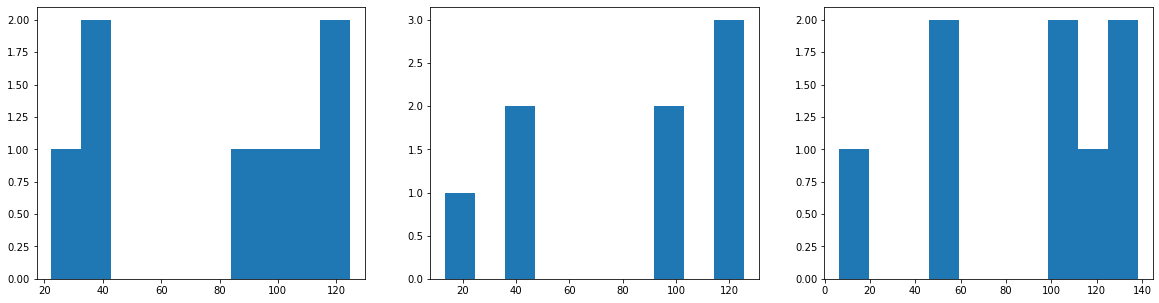

In [227]:
# inspect split data
nsamples = np.zeros(len(split_data))
for (ix, x) in enumerate(split_data):
    print(x, split_data[x][1].shape[0])
    
e = np.array(error)
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for idx in range(3):
    axs[idx].hist(e[:,idx])
plt.show()

In [88]:
# fit GLMNET in parallel (ncores) with cross validation to find lambda

# alphas = [.9, 1.]
alpha = 1.0
models = {x: [] for x in split_data}
ncross = 10
nx = len(split_data)
for (ix, x) in enumerate(split_data):
    this_x_train, this_y_train = split_data[x]
    print(f'Computing {ncross} cross-validations for model {ix} of {nx} ({x}) ... ', end='')
    start_time = time.time()
    models[x] = cvglmnet(x = this_x_train.copy(), y = this_y_train.copy(), family='mgaussian', parallel=ncores, ptype = 'mse', nfolds = ncross, alpha=alpha)
    print(" took %s seconds" % (time.time() - start_time))

Computing 10 cross-validations for model 0 of 8 ((0, 0, 0)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 7335.409673690796 seconds
Computing 10 cross-validations for model 1 of 8 ((0, 0, 1)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 4197.989711523056 seconds
Computing 10 cross-validations for model 2 of 8 ((0, 1, 0)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 4973.327823400497 seconds
Computing 10 cross-validations for model 3 of 8 ((0, 1, 1)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 2853.176318883896 seconds
Computing 10 cross-validations for model 4 of 8 ((1, 0, 0)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 2878.9547266960144 seconds
Computing 10 cross-validations for model 5 of 8 ((1, 0, 1)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 3433.3752496242523 seconds
Computing 10 cross-validations for model 6 of 8 ((1, 1, 0)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 2245.6446545124054 seconds
Computing 10 cross-validations for model 7 of 8 ((1, 1, 1)) ... 

[status]	Parallel glmnet cv with 28 cores


 took 1537.4455499649048 seconds


In [89]:
output_file = os.path.join(results_prefix, f'cf_alpha_1.0_{nint}x{nint}x{nint}.pickle')
print(output_file)
with open(output_file, 'wb') as f:
    pickle.dump(models, f)

/mnt/nfs/proj/in-vitro/Leonardo/glmnet/fits/cf_alpha_1.0_2x2x2.pickle


In [178]:
# DEBUG
# _, uidx = np.unique(y_train, return_index=True, axis=0)
# for (idx, x) in enumerate(y_train[uidx, :]):
#     if x[0] < 2000 and x[3] < 2000 and x[1] > 3000:
#         print(idx, x)

In [220]:
# find the model with predictions closest to original range (sum over all analytes) and compute RMSE of each analyte for that model 

x_to_pred = x_val
y_to_pred = y_val

# DEBUG
# x_to_pred = x_train
# y_to_pred = y_train

# x_to_pred = x_train[uidx[307], :][None, :]
# y_to_pred = y_train[uidx[307], :][None, :]
# x_to_pred = x_train[[uidx[307], uidx[210]], :]
# y_to_pred = y_train[[uidx[307], uidx[210]], :]

# generate the predictions for each model
y_hats = np.zeros((len(models), y_to_pred.shape[0], y_to_pred.shape[1]))
for (ix, x) in enumerate(models):
    print(f'{ix} of {nx} ({x})... ', end='')
    model = models[x]
    start_time = time.time()
#     y_hat = cvglmnetPredict(fit, newx = x_to_pred, s='lambda_min')
    y_hat = cvglmnetPredict(model, newx = x_to_pred, s='lambda_1se')
    
    # DEBUG
#     y_hat = y_val[:,:,None]*(1.+0.1*np.random.randn(y_val.shape[0], y_val.shape[1], 1))

    y_hats[ix,:,:] = y_hat[:,:,0]
    print(" took %s seconds" % (time.time() - start_time))


0 of 8 ((0, 0, 0))...  took 1.5618948936462402 seconds
1 of 8 ((0, 0, 1))...  took 1.6296138763427734 seconds
2 of 8 ((0, 1, 0))...  took 1.570612907409668 seconds
3 of 8 ((0, 1, 1))...  took 0.8295671939849854 seconds
4 of 8 ((1, 0, 0))...  took 0.7830884456634521 seconds
5 of 8 ((1, 0, 1))...  took 0.7845678329467773 seconds
6 of 8 ((1, 1, 0))...  took 0.7926273345947266 seconds
7 of 8 ((1, 1, 1))...  took 0.7822914123535156 seconds


In [221]:
# print(ranges)
# compute the differences to original intervals
diff_y_hats = np.zeros(y_hats[:,:,analytes].shape)
diff_y_true = np.zeros(y_hats[:,:,analytes].shape)
for (ix,x) in enumerate(models):
#     print(x)
    for ia in range(len(analytes)):
#         print(ix, ia, analytes[ia], x[ia], ranges[ia][x[ia]])
        diff_y_hats[ix,:,ia] = (y_hats[ix,:,analytes[ia]] - ranges[ia][x[ia]])**2
        # save that for comparing how often the predicted model matches the "ideal" model 
        diff_y_true[ix,:,ia] = (y_to_pred[:,analytes[ia]] - ranges[ia][x[ia]])**2 

# find the model with sum of predictions closest to original intervals
model_e = np.sqrt(np.sum(diff_y_hats,axis=2)) # take sqrt to make it easier to debug, doesn't change the ordering
min_idx = model_e.argmin(axis=0)

# compute the RMSE for each sample (there is certainly a more pythonic way to do that, but that works)
rmse = np.zeros((4,), dtype=np.float64)
for (sample_idx, model_idx) in enumerate(min_idx):
    rmse += (y_hats[model_idx, sample_idx, :] - y_to_pred[sample_idx, :])**2/y_to_pred.shape[0]

rmse = np.sqrt(rmse) 

for (armse, name) in zip(rmse,names):
    print('%s: %4.5f'%(name,armse), flush=True)


DA: 1242.49141
5HT: 506.27502
pH: 0.15365
NE: 2548.88413


How often the predicted model matches the expected model? 0.48514193025141933


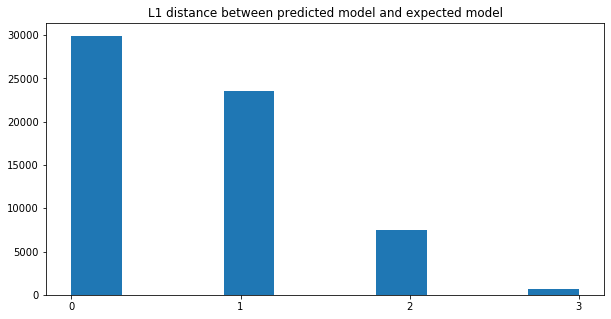

In [222]:
# find the model with sum of predictions closest to original intervals
real_model_e = np.sqrt(np.sum(diff_y_true,axis=2)) # take sqrt to make it easier to debug, doesn't change the ordering
real_min_idx = real_model_e.argmin(axis=0)
ratio_same = sum(real_min_idx == min_idx)/min_idx.shape[0]
print(f'How often the predicted model matches the expected model? {ratio_same}')
# fig, axs = plt.subplots(1, 2, sharey=False, sharex=False, tight_layout=True, figsize=(20,10))
x = np.array(list(split_data.keys()))
d = np.zeros(min_idx.shape)
for sample in range(len(d)):
    d[sample] = sum(abs(x[min_idx[sample], :] - x[real_min_idx[sample], :]))
fig, axs = plt.subplots(figsize=(10,5))
axs.hist(d)
axs.set_xticks(range(0, x.shape[1]+1))
axs.set_title('L1 distance between predicted model and expected model')
plt.show()

In [223]:
# DEBUG
# print(y_val_s)
# print(y_hats)
# x = np.sqrt(diff_y_hats)
# print(x)
# print(model_e)
# print(min_idx)
# # compute the RMSE for each sample (there is certainly a more pythonic way to do that, but that works)
# rmse = np.zeros((4,), dtype=np.float64)
# for (sample_idx, model_idx) in enumerate(min_idx):
#     print(sample_idx, model_idx)
#     rmse += (y_hats[model_idx, sample_idx, :] - y_val_s[sample_idx, :])**2/y_val_s.shape[0]

# rmse = np.sqrt(rmse) 
# print(rmse)

In [224]:
# DEBUG
# x1=(np.array([1969.4478911  , 905.53209513 ,  7.41054667 ,3656.49362621]) - np.array([2232.    ,     729.     ,      7.4000001, 3727.  ]))**2
# x2=(np.array([ -55.492296  ,  4099.18583448   ,  7.40349391 ,   80.2708897]) - np.array([    0.    ,    4099.       ,    7.4000001  ,  0.           ]))**2
# print(np.sqrt((x1+x2)/y_val_s.shape[0]))

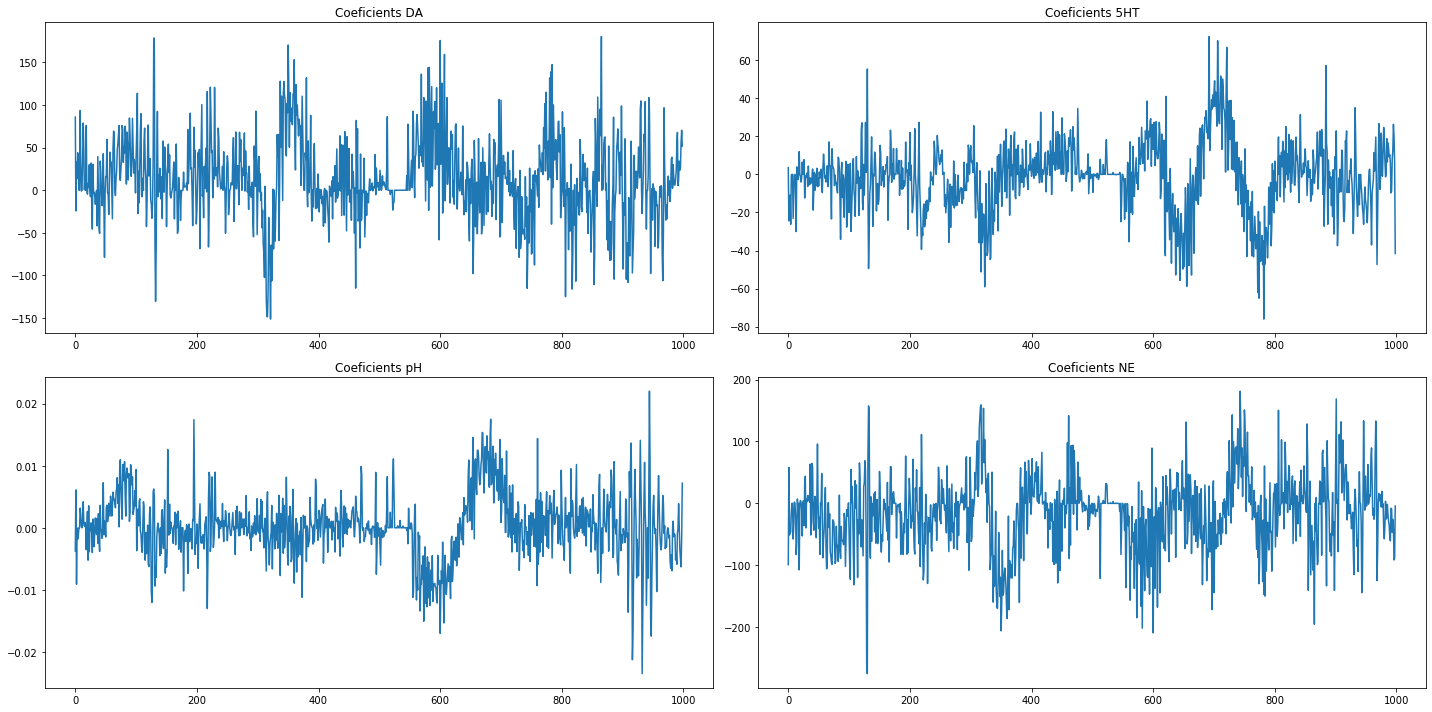

In [225]:
# inspect the weights for a model in given interval of concentrations (cell in the grid) 
cell=(0,0,0)
l = np.where([x == models[cell]['lambda_1se'][0] for x in models[cell]['lambdau']])[0][0]
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, tight_layout=True, figsize=(20,10))
for ia in range(4):
    idx = np.unravel_index(ia, axs.shape)
    x = models[cell]['glmnet_fit']['beta'][ia][:, l]
    axs[idx].plot(x)
    axs[idx].set_title("Coeficients %s"%names[ia])